In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from fastai.imports import *
from fastai.dataset import *
# from pathlib import Path
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [5]:
PATH = Path("../../Stylify")
list(PATH.iterdir())

[PosixPath('../../Stylify/list_eval_partition.txt'),
 PosixPath('../../Stylify/list_bbox.txt'),
 PosixPath('../../Stylify/fn_cat.csv'),
 PosixPath('../../Stylify/.git'),
 PosixPath('../../Stylify/img.zip'),
 PosixPath('../../Stylify/list_attr_img.txt'),
 PosixPath('../../Stylify/tmp'),
 PosixPath('../../Stylify/list_category_img.txt'),
 PosixPath('../../Stylify/.ipynb_checkpoints'),
 PosixPath('../../Stylify/img'),
 PosixPath('../../Stylify/list_category_cloth.txt')]

In [ ]:
import nmslib

In [6]:
def extr_data_txt(path):
    with open(path, "r") as f:
        data = []
        for itr, line in enumerate(f):
            if itr >= 2:
                data.append(line.split())
    return data

In [7]:
idx2cat = dict((i, cat[0]) for i, cat in enumerate(extr_data_txt(PATH/'list_category_cloth.txt')))
cat2idx = dict((v,k) for k,v in idx2cat.items())
idx2cat[2], cat2idx["Blouse"]

('Blouse', 2)

In [8]:
train_test_valid_anot = pd.DataFrame(extr_data_txt(PATH/'list_eval_partition.txt'),columns=['Path', 'type'])
# train_test_valid_anot.to_csv(PATH/'train_test_valid_anot.csv' ,index=False)
train_test_valid_anot.head()

,Path,type
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,train
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,train
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,val
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,train
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,test


In [9]:
fileName2cat = pd.DataFrame(extr_data_txt(PATH/'list_category_img.txt'), columns=['Path', 'cat'])
fileName2cat['cat'] = fileName2cat['cat'].apply(lambda x: int(x)-1) # Categories start with 1, fixing it.
# filename2cat.to_csv(PATH/'filename2cat.csv' ,index=False)
fileName2cat.head()

,Path,cat
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,2
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,2
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,2
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,2
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,2


In [10]:
fileName2bbox = pd.DataFrame(extr_data_txt(PATH/'list_bbox.txt'), columns=['Path', 'x1', 'y1', 'x2', 'y2'])
# bbox_img.to_csv(PATH/'bbox_img.csv' ,index=False)
fileName2bbox["x1"] = pd.to_numeric(fileName2bbox["x1"])
fileName2bbox["y1"] = pd.to_numeric(fileName2bbox["y1"])
fileName2bbox["x2"] = pd.to_numeric(fileName2bbox["x2"])
fileName2bbox["y2"] = pd.to_numeric(fileName2bbox["y2"])
fileName2bbox.head()

,Path,x1,y1,x2,y2
0,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,67,59,155,161
1,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65,65,156,200
2,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,51,62,167,182
3,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,46,88,166,262
4,img/Sheer_Pleated-Front_Blouse/img_00000006.jpg,47,67,211,241


In [11]:
final_ann = fileName2bbox.merge(train_test_valid_anot).merge(fileName2cat)
final_ann.head()

,Path,x1,y1,x2,y2,type,cat
0,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,67,59,155,161,train,2
1,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65,65,156,200,val,2
2,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,51,62,167,182,train,2
3,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,46,88,166,262,test,2
4,img/Sheer_Pleated-Front_Blouse/img_00000006.jpg,47,67,211,241,val,2


In [12]:
final_ann["image_id"] = range(0, len(final_ann))
train_df = final_ann[final_ann["type"]=="train"]
val_df = final_ann[final_ann["type"]=="val"]
test_df = final_ann[final_ann["type"]=="test"]

len(train_df), len(val_df), len(test_df)

(209221, 40000, 40000)

In [13]:
file_names = dict((ID,filename) for ID, filename in zip(final_ann["image_id"], final_ann["Path"]))
file_indexes = [ID for ID in final_ann["image_id"]]
len(file_names), len(file_indexes)

(289221, 289221)

In [14]:
image_ann = dict((ID, [(np.array([y1,x1,y2,x2]), cat_id)])
                 for ID, cat_id, x1, y1, x2, y2 in zip(final_ann["image_id"],
                                                       final_ann["cat"],
                                                       final_ann["x1"],
                                                       final_ann["y1"],
                                                       final_ann["x2"],
                                                       final_ann["y2"] ))



image_ann[1]

[(array([ 65,  65, 200, 156]), 2)]

In [17]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
    draw_rect(ax, b)
    draw_text(ax, b[:2], idx2cat[c], sz=16)
        
def draw_idx(i):
    im_a = image_ann[i]
    im = open_image(PATH/file_names[i])
    print(im.shape)
    print(im_a)
    print(file_names[i])
    draw_im(im, im_a)

(250, 200, 3)
[(array([ 62,  51, 182, 167]), 2)]
img/Sheer_Pleated-Front_Blouse/img_00000004.jpg


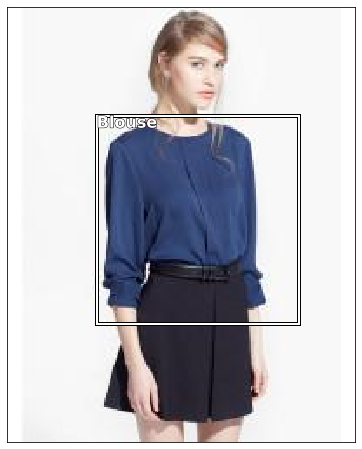

In [18]:
draw_idx(2)

In [19]:
cat = [[p[1] for p in image_ann[o]] for o in file_indexes]
cats = [" ".join(str(p) for p in o) for o in cat]

In [20]:
class_cat_df = pd.DataFrame({"fn": [file_names[o] for o in file_indexes],
                            "cat": [idx2cat[int(o)] for o in cats]}, columns=["fn","cat"])
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/"tmp/fn_cat.csv"
class_cat_df.to_csv(CSV, index=False)
class_cat_df.head()

,fn,cat
0,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,Blouse
1,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,Blouse
2,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,Blouse
3,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,Blouse
4,img/Sheer_Pleated-Front_Blouse/img_00000006.jpg,Blouse


In [21]:
f_model = resnet34
sz=300
bs=32

In [37]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md_cat = ImageClassifierData.from_csv(PATH, "", CSV, tfms=tfms)

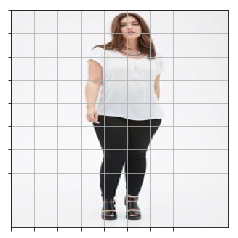

In [38]:
x, y = next(iter(md_cat.val_dl))
show_img(md_cat.val_ds.denorm(to_np(x[0]))[0])

In [23]:
bb = [np.concatenate([p[0] for p in image_ann[o]]) for o in file_indexes]
bbs = [" ".join(str(p) for p in o) for o in bb]

In [24]:
regress_bbox_df = pd.DataFrame({'fn': [file_names[o] for o in file_indexes], 'bbox': bbs}, columns=['fn','bbox'])
BB_CSV = PATH/"tmp/fn_bbx"
regress_bbox_df.to_csv(BB_CSV, index=False)
regress_bbox_df.head()

,fn,bbox
0,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,59 67 161 155
1,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,65 65 200 156
2,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,62 51 182 167
3,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,88 46 262 166
4,img/Sheer_Pleated-Front_Blouse/img_00000006.jpg,67 47 241 211


In [40]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, "", BB_CSV, tfms=tfms, continuous=True)

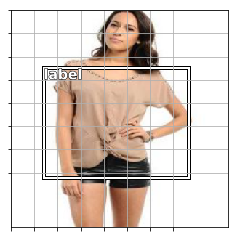

In [41]:
x,y=next(iter(md.aug_dl))
ima = md.val_ds.denorm(to_np(x))[2]
b = bb_hw(to_np(y[2])); b
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], 'label')

In [42]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [43]:
trn_ds_new = ConcatLblDataset(md.trn_ds, md_cat.trn_y)
val_ds_new = ConcatLblDataset(md.val_ds, md_cat.val_y)

In [44]:
md.trn_dl.dataset = trn_ds_new
md.val_dl.dataset = val_ds_new

In [165]:
x,y = next(iter(md.val_dl))

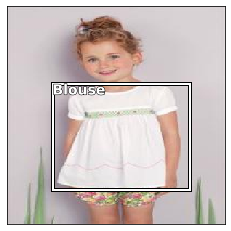

In [166]:
ima = md.val_ds.ds.denorm(to_np(x))[62]
b = bb_hw(to_np(y[0][62]));
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md_cat.classes[y[1][62]])

In [167]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

# learn.crit = detn_loss
# learn.metrics = [detn_acc, detn_l1]

In [30]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_offsets = np.linspace(anc_offset, 1-anc_offset, anc_grid)
anc_offset, anc_offsets

anc_x = np.repeat(anc_offsets, anc_grid_number)
anc_x

anc_y = np.tile(anc_offsets, anc_grid)
anc_y

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_ctrs

anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anc_sizes

anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()

grid_sizes = V(np.array([1/anc_grid]), requires_grad=False).unsqueeze(1)

def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.2500  0.2500  0.5000
 0.0000  0.5000  0.2500  0.7500
 0.0000  0.7500  0.2500  1.0000
 0.2500  0.0000  0.5000  0.2500
 0.2500  0.2500  0.5000  0.5000
 0.2500  0.5000  0.5000  0.7500
 0.2500  0.7500  0.5000  1.0000
 0.5000  0.0000  0.7500  0.2500
 0.5000  0.2500  0.7500  0.5000
 0.5000  0.5000  0.7500  0.7500
 0.5000  0.7500  0.7500  1.0000
 0.7500  0.0000  1.0000  0.2500
 0.7500  0.2500  1.0000  0.5000
 0.7500  0.5000  1.0000  0.7500
 0.7500  0.7500  1.0000  1.0000
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [31]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = image_ann[i]
    im = open_image(IMG_PATH/file_names[i])
    draw_im(im, im_a)

In [55]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    clas = [clas]
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(idx2cat) else idx2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [45]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[array([ 99.,  60., 126., 100.], dtype=float32)]
[array([ 75.,  74., 120., 170.], dtype=float32)]
[array([ 45.,  80., 200., 152.], dtype=float32)]
[array([ 88.,  47., 129., 181.], dtype=float32)]
[array([ 93.,  48., 109., 110.], dtype=float32)]
[array([ 75.,  69., 152., 147.], dtype=float32)]
[array([ 66.,  75., 189., 161.], dtype=float32)]
[array([ 18.,  15., 257., 269.], dtype=float32)]
[array([ 71.,  79., 170., 217.], dtype=float32)]
[array([  3.,  90., 285., 207.], dtype=float32)]
[array([ 62.,  78., 171., 221.], dtype=float32)]
[array([ 74.,  73., 157., 194.], dtype=float32)]


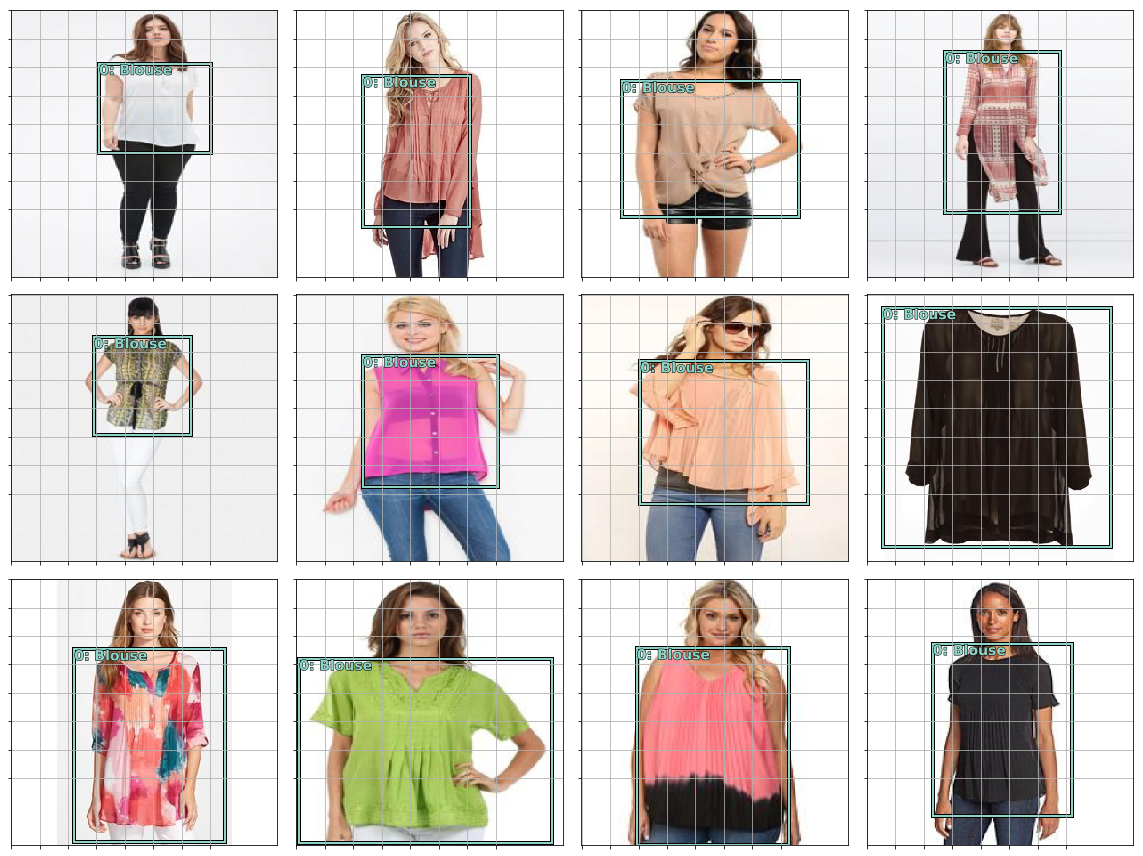

In [56]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()